In [30]:
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import folium
from tqdm import tqdm
import seaborn as sns


# Caso 1

Caso 1: Optimización de rutas para los pedidos del último mes disponible Utilizar los datos actuales de clientes, vehículos y pedidos para planificar las rutas de entrega, minimizando el coste total y maximizando el número de entregas realizadas dentro de las restricciones de capacidad, autonomía y vehículos disponibles.

### 1º Algoritmo optimización: hill climbing

In [ ]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_location.xlsx"
df_location = pd.read_excel(path_df_location)

path_df_vehicle = "../dataset/df_vehicle.xlsx"
df_vehicle = pd.read_excel(path_df_vehicle)

path_df_orders = "../dataset/df_orders.xlsx"
df_orders = pd.read_excel(path_df_orders)

path_df_distance_km = "../dataset/df_distance_km.xlsx"
df_distance_km = pd.read_excel(path_df_distance_km)

In [ ]:
# Crear Lista de Clientes y Validación
# Lista de clientes más el almacén al inicio y al final
clientes = ['Almacén'] + df_location['Cliente'].tolist() + ['Almacén']

# Validar pedidos individuales antes de asignarlos a vehículos
def validate_clients(orders, vehicles):
    for index, row in orders.iterrows():
        if row['order_demand'] > vehicles['capacidad_kg'].max():
            print(f"El cliente {row['cliente']} tiene una demanda que excede la capacidad de todos los vehículos.")
            return False
    return True

if not validate_clients(df_orders, df_vehicle):
    raise ValueError("Existen pedidos que no pueden ser atendidos por ningún vehículo.")

Definición de Funciones Auxiliares


In [ ]:
# Función para calcular el costo de una ruta considerando restricciones de carga y autonomía
def calculate_cost(route, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    total_distance = 0
    total_load = 0
    total_cost = 0

    for i in range(len(route) - 1):
        segment_distance = distances.loc[route[i], route[i+1]]

        if segment_distance == 0 or total_distance + segment_distance > vehicle_range:
            return float('inf')  # Ruta no viable por autonomía

        total_distance += segment_distance

        if route[i] != 'Almacén':  # Ignorar el almacén para la carga
            order_row = orders.loc[orders['cliente'] == route[i], 'order_demand']
            if not order_row.empty:
                total_load += order_row.iloc[0]

        if total_load > vehicle_capacity:
            return float('inf')  # Ruta no viable por carga

        total_cost += segment_distance * vehicle_cost_km

    return total_cost

# Función para generar una solución inicial aleatoria
def generate_initial_solution(clientes):
    solution = clientes[:]
    random.shuffle(solution)
    return solution

# Función para obtener vecinos intercambiando dos elementos de la ruta
def get_neighbors(route):
    neighbors = []
    if len(route) > 2:  # Asegura que hay más de un cliente además del almacén
        for i in range(1, len(route)-1):
            for j in range(i + 1, len(route)-1):
                new_route = route[:]
                new_route[i], new_route[j] = new_route[j], new_route[i]
                neighbors.append(new_route)
    return neighbors if neighbors else [route]  # Retorna la ruta actual si no hay vecinos

# Función principal del algoritmo Hill Climbing
def hill_climbing(clientes, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    current_solution = generate_initial_solution(clientes)
    current_cost = calculate_cost(current_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
    
    while True:
        neighbors = get_neighbors(current_solution)
        if not neighbors:
            print("No hay vecinos posibles, terminando la optimización.")
            break
        
        next_solution = min(neighbors, key=lambda r: calculate_cost(r, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km))
        next_cost = calculate_cost(next_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
        
        if next_cost >= current_cost:
            break
        
        current_solution, current_cost = next_solution, next_cost
    
    return current_solution, current_cost




In [ ]:
# Calcular el costo total de todas las subrutas de un vehículo
def calculate_total_cost(subroutes, distances, vehicle_cost_km):
    total_cost = 0
    for subroute in subroutes:
        subroute_cost = 0
        for i in range(len(subroute) - 1):
            segment_distance = distances.loc[subroute[i], subroute[i + 1]]
            if segment_distance == 0.0:  # Conexión inválida
                print(f"Error: Distancia inválida entre {subroute[i]} y {subroute[i + 1]}.")
                return float('inf')  # Ruta inválida
            subroute_cost += segment_distance * vehicle_cost_km
        total_cost += subroute_cost
    return total_cost

In [ ]:
# Dividir rutas basadas en restricciones de capacidad y autonomía
def split_route_by_constraints(route, distances, orders, vehicle_capacity, vehicle_range):
    subroutes = []
    current_subroute = ['Almacén']
    current_load = 0
    current_distance = 0

    for cliente in route:
        if cliente == 'Almacén':
            continue  # Ignorar el almacén dentro de la lógica
        order_demand = orders.loc[orders['cliente'] == cliente, 'order_demand'].iloc[0]
        last_stop = current_subroute[-1]
        segment_distance = distances.loc[last_stop, cliente]

        # Verificar si se exceden las restricciones de carga o autonomía
        if (current_load + order_demand > vehicle_capacity or
                current_distance + segment_distance > vehicle_range):
            # Cierra la subruta y empieza una nueva
            current_subroute.append('Almacén')
            subroutes.append(current_subroute)
            current_subroute = ['Almacén', cliente]
            current_load = order_demand
            current_distance = distances.loc['Almacén', cliente]
        else:
            current_subroute.append(cliente)
            current_load += order_demand
            current_distance += segment_distance

    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    subroutes.append(current_subroute)

    return subroutes


# Corregir subrutas con conexiones inválidas
def correct_invalid_subroutes(subroute, distances):
    corrected_subroutes = []
    current_subroute = ['Almacén']
    
    for i in range(1, len(subroute)):
        segment_distance = distances.loc[subroute[i - 1], subroute[i]]
        
        if segment_distance == 0.0:  # Conexión inválida
            print(f"Error: Distancia inválida entre {subroute[i - 1]} y {subroute[i]}. Dividiendo la subruta.")
            current_subroute.append('Almacén')
            corrected_subroutes.append(current_subroute)
            current_subroute = ['Almacén', subroute[i]]
        else:
            current_subroute.append(subroute[i])
    
    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    corrected_subroutes.append(current_subroute)
    
    return corrected_subroutes




In [ ]:
# Agrupamiento de clientes usando K-Means
num_vehicles = len(df_vehicle)
kmeans = KMeans(n_clusters=num_vehicles, random_state=42, n_init=10)
df_location['cluster'] = kmeans.fit_predict(df_location[['Latitud', 'Longitud']])

vehicle_routes = {}
vehicle_costs = {}

for vehicle_id in range(num_vehicles):
    cluster_customers = df_location[df_location['cluster'] == vehicle_id]['Cliente'].tolist() + ['Almacén']
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']

    # Optimización inicial de la ruta
    optimal_route, _ = hill_climbing(
        cluster_customers,
        df_distance_km.set_index('CLIENTES'),
        df_orders,
        vehicle_capacity,
        vehicle_range,
        vehicle_cost_km
    )

    # Corregir conexiones inválidas
    corrected_subroutes = correct_invalid_subroutes(
        optimal_route,
        df_distance_km.set_index('CLIENTES')
    )

    # Dividir cada subruta por restricciones
    final_subroutes = []
    for subroute in corrected_subroutes:
        final_subroutes.extend(
            split_route_by_constraints(
                subroute,
                df_distance_km.set_index('CLIENTES'),
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Calcular el costo total de las subrutas finales
    total_cost = calculate_total_cost(final_subroutes, df_distance_km.set_index('CLIENTES'), vehicle_cost_km)

    vehicle_routes[vehicle_id] = final_subroutes
    vehicle_costs[vehicle_id] = total_cost





Error: Distancia inválida entre Cliente_13 y Cliente_7. Dividiendo la subruta.
Error: Distancia inválida entre Cliente_7 y Cliente_3. Dividiendo la subruta.


In [ ]:
# Identificar clientes no atendidos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_no_atendidos = set(df_orders['cliente']) - entregados

if clientes_no_atendidos:
    print(f"Clientes no atendidos: {clientes_no_atendidos}")
    
    # Redistribuir clientes no atendidos
    for cliente in clientes_no_atendidos:
        reasignado = False
        for vehicle_id, routes in vehicle_routes.items():
            # Verificar capacidad y autonomía disponibles
            vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
            vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
            distances = df_distance_km.set_index('CLIENTES')
            
            # Verificar si el cliente puede ser agregado a alguna subruta existente
            for subroute in routes:
                subroute_cost = calculate_cost(
                    subroute + [cliente, 'Almacén'], distances, df_orders, vehicle_capacity, vehicle_range, vehicle_cost_km
                )
                if subroute_cost < float('inf'):
                    print(f"Reasignando {cliente} al Vehículo {vehicle_id + 1} en subruta existente.")
                    subroute.insert(-1, cliente)  # Insertar el cliente antes del 'Almacén'
                    reasignado = True
                    break
            
            # Si no se reasignó a una subruta existente, crear una nueva subruta
            if not reasignado:
                print(f"Creando nueva subruta para {cliente} en Vehículo {vehicle_id + 1}.")
                vehicle_routes[vehicle_id].append(['Almacén', cliente, 'Almacén'])
                reasignado = True
            
            if reasignado:
                break


Clientes no atendidos: {'Cliente_10', 'Cliente_20', 'Cliente_13'}
Creando nueva subruta para Cliente_10 en Vehículo 1.
Reasignando Cliente_20 al Vehículo 1 en subruta existente.
Creando nueva subruta para Cliente_13 en Vehículo 1.


In [ ]:
print(vehicle_routes)
print(vehicle_costs)	

{0: [['Almacén', 'Cliente_12', 'Cliente_18', 'Almacén'], ['Almacén', 'Cliente_10', 'Cliente_20', 'Almacén'], ['Almacén', 'Cliente_13', 'Almacén']], 1: [['Almacén', 'Cliente_16', 'Cliente_5', 'Cliente_6', 'Cliente_17', 'Almacén'], ['Almacén', 'Cliente_4', 'Cliente_9', 'Cliente_1', 'Cliente_14', 'Almacén'], ['Almacén', 'Cliente_11', 'Almacén']], 2: [['Almacén']], 3: [['Almacén'], ['Almacén', 'Cliente_7', 'Almacén'], ['Almacén', 'Cliente_3', 'Cliente_2', 'Almacén']], 4: [['Almacén', 'Cliente_15', 'Cliente_8', 'Almacén']], 5: [['Almacén', 'Cliente_19', 'Almacén']]}
{0: np.float64(5.730899999999999), 1: np.float64(8.069362), 2: 0, 3: np.float64(9.47682), 4: np.float64(13.584928), 5: np.float64(6.170304000000001)}


In [ ]:
# Identificar vehículos con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]

# Mostrar cuáles vehículos tienen costos infinitos
if problematic_vehicles:
    print(f"Vehículos con costos infinitos: {[v + 1 for v in problematic_vehicles]}")
else:
    print("No hay vehículos con costos infinitos.")


No hay vehículos con costos infinitos.


In [ ]:
# Asegurar que todos los vehículos realicen al menos una entrega
vehicles_without_deliveries = [vid for vid, cost in vehicle_costs.items() if cost == 0]
if vehicles_without_deliveries:
    print(f"Vehículos sin entregas significativas: {[v + 1 for v in vehicles_without_deliveries]}")
    
    for vehicle_id in vehicles_without_deliveries:
        for other_vehicle_id in vehicle_routes:
            if other_vehicle_id != vehicle_id:
                for subroute in vehicle_routes[other_vehicle_id]:
                    for client in subroute:
                        if client != 'Almacén':  # Evitar el almacén
                            print(f"Reasignando {client} al Vehículo {vehicle_id + 1}.")
                            
                            # Crear una nueva subruta para el cliente reasignado
                            vehicle_routes[vehicle_id] = [['Almacén', client, 'Almacén']]
                            
                            # Eliminar cliente de la subruta original
                            subroute.remove(client)
                            
                            # Si la subruta queda vacía, eliminarla
                            if len(subroute) <= 2:
                                vehicle_routes[other_vehicle_id].remove(subroute)
                            
                            # Recalcular el costo para el vehículo
                            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
                            distances = df_distance_km.set_index('CLIENTES')
                            vehicle_costs[vehicle_id] = calculate_total_cost(vehicle_routes[vehicle_id], distances, vehicle_cost_km)
                            break
                    if vehicle_costs[vehicle_id] > 0:
                        break
            if vehicle_costs[vehicle_id] > 0:
                break



Vehículos sin entregas significativas: [3]
Reasignando Cliente_12 al Vehículo 3.


In [ ]:
# Corregir subrutas con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]
for vehicle_id in problematic_vehicles:
    print(f"Corrigiendo subrutas para el Vehículo {vehicle_id + 1}...")
    
    corrected_subroutes = []
    distances = df_distance_km.set_index('CLIENTES')
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']

    for subroute in vehicle_routes[vehicle_id]:
        corrected_subroutes.extend(
            split_route_by_constraints(
                subroute,
                distances,
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Actualizar las subrutas corregidas para el vehículo
    vehicle_routes[vehicle_id] = corrected_subroutes

    # Recalcular el costo total para las subrutas corregidas
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
    total_cost = calculate_total_cost(corrected_subroutes, distances, vehicle_cost_km)
    vehicle_costs[vehicle_id] = total_cost

    print(f"Subrutas Corregidas para el Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(corrected_subroutes, 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print(f"Costo Total Corregido: {total_cost}")



In [ ]:
# Mostrar las rutas óptimas y los costos mínimos para cada vehículo
for vehicle_id in vehicle_routes:
    print(f"Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(vehicle_routes[vehicle_id], 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print("Costo Total:", vehicle_costs[vehicle_id])
    print("\n")


Vehículo 1:
  Subruta 1: Almacén -> Cliente_18 -> Almacén
  Subruta 2: Almacén -> Cliente_10 -> Cliente_20 -> Almacén
  Subruta 3: Almacén -> Cliente_13 -> Almacén
Costo Total: 5.730899999999999


Vehículo 2:
  Subruta 1: Almacén -> Cliente_16 -> Cliente_5 -> Cliente_6 -> Cliente_17 -> Almacén
  Subruta 2: Almacén -> Cliente_4 -> Cliente_9 -> Cliente_1 -> Cliente_14 -> Almacén
  Subruta 3: Almacén -> Cliente_11 -> Almacén
Costo Total: 8.069362


Vehículo 3:
  Subruta 1: Almacén -> Cliente_12 -> Almacén
Costo Total: 4.0949599999999995


Vehículo 4:
  Subruta 1: Almacén
  Subruta 2: Almacén -> Cliente_7 -> Almacén
  Subruta 3: Almacén -> Cliente_3 -> Cliente_2 -> Almacén
Costo Total: 9.47682


Vehículo 5:
  Subruta 1: Almacén -> Cliente_15 -> Cliente_8 -> Almacén
Costo Total: 13.584928


Vehículo 6:
  Subruta 1: Almacén -> Cliente_19 -> Almacén
Costo Total: 6.170304000000001




In [ ]:
# Validar que todos los clientes están cubiertos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_pendientes = set(df_orders['cliente']) - entregados

if clientes_pendientes:
    print(f"Clientes no atendidos: {clientes_pendientes}")
else:
    print("Todos los clientes están atendidos.")

# Validar restricciones de capacidad y autonomía
for vehicle_id, routes in vehicle_routes.items():
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    distances = df_distance_km.set_index('CLIENTES')
    
    for subroute in routes:
        carga_total = sum(df_orders.loc[df_orders['cliente'] == client, 'order_demand'].iloc[0] for client in subroute if client != 'Almacén')
        distancia_total = sum(distances.loc[subroute[i], subroute[i+1]] for i in range(len(subroute)-1))
        
        if carga_total > vehicle_capacity:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su capacidad en la subruta {subroute}.")
        if distancia_total > vehicle_range:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su autonomía en la subruta {subroute}.")


Todos los clientes están atendidos.


Representación Gráfica

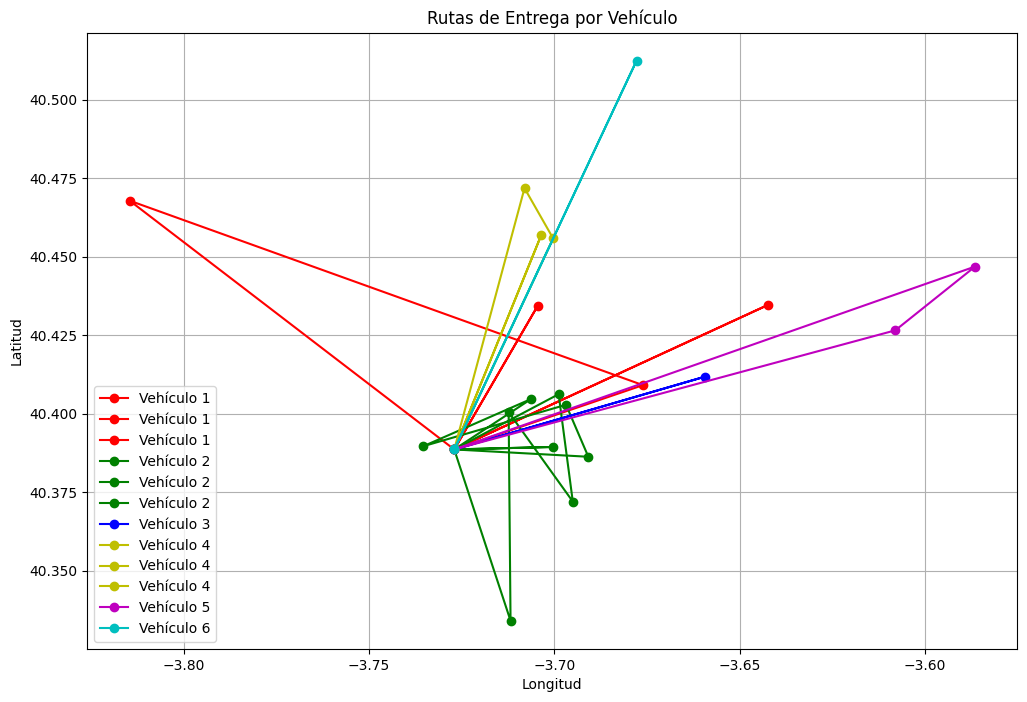

In [ ]:
# Crear representación gráfica de las rutas
def plot_routes(vehicle_routes, df_location):
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'orange', 'purple']

    # Dibujar las rutas de cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        for subroute in routes:
            x_coords = [df_location[df_location['Cliente'] == client]['Longitud'].iloc[0] for client in subroute if client != 'Almacén']
            y_coords = [df_location[df_location['Cliente'] == client]['Latitud'].iloc[0] for client in subroute if client != 'Almacén']
            
            # Agregar las coordenadas del almacén
            x_coords = [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]] + x_coords + [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]]
            y_coords = [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]] + y_coords + [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]]
            
            plt.plot(x_coords, y_coords, marker='o', label=f'Vehículo {vehicle_id + 1}', color=colors[vehicle_id % len(colors)])
    
    # Añadir detalles al gráfico
    plt.title("Rutas de Entrega por Vehículo")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar
plot_routes(vehicle_routes, df_location)


In [ ]:
#Generar Mapas Interactivos	
def generate_route_map(vehicle_routes, df_location):
    # Crear un mapa centrado en la ubicación del almacén
    almacen_coords = df_location[df_location['Cliente'] == 'Almacén'][['Latitud', 'Longitud']].iloc[0]
    route_map = folium.Map(location=[almacen_coords['Latitud'], almacen_coords['Longitud']], zoom_start=12)

    # Colores para las rutas de los vehículos
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen']
    
    # Dibujar rutas para cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        color = colors[vehicle_id % len(colors)]
        for subroute in routes:
            # Coordenadas de los clientes en la subruta
            subroute_coords = [
                (df_location[df_location['Cliente'] == client]['Latitud'].iloc[0], 
                 df_location[df_location['Cliente'] == client]['Longitud'].iloc[0])
                for client in subroute
            ]
            # Añadir la subruta al mapa
            folium.PolyLine(subroute_coords, color=color, weight=5, opacity=0.8).add_to(route_map)
            
            # Añadir marcadores para cada cliente en la subruta
            for client in subroute:
                client_coords = df_location[df_location['Cliente'] == client][['Latitud', 'Longitud']].iloc[0]
                folium.Marker(
                    location=[client_coords['Latitud'], client_coords['Longitud']],
                    popup=f'{client} (Vehículo {vehicle_id + 1})',
                    icon=folium.Icon(color=color)
                ).add_to(route_map)
    
    # Guardar el mapa en un archivo HTML
    route_map.save("mapa_rutas_hill_climbing.html")
    print("Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.")

# Generar el mapa
generate_route_map(vehicle_routes, df_location)


Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.


## 2º Algoritmo optimización: tabu search

In [ ]:
df_distance_km = "../dataset/df_distance_km.xlsx"
df = pd.read_excel(df_distance_km)
df.head()

In [ ]:
df_clientes = df["CLIENTES"]
df_clientes

In [ ]:
#eliminamos la columna CLIENTES
df = df.drop(columns=["CLIENTES"])
distance_km_array = df.to_numpy()
distance_km_array

In [ ]:
# Cargar datos de vehículos
df_vehicle = pd.read_excel('../dataset/df_vehicle.xlsx')
df_vehicle.head()

In [ ]:
# Crear lista de diccionarios con información de cada vehículo
vehiculos = df_vehicle.to_dict('records')  # Convierte cada fila en un diccionario
vehiculos

In [ ]:
# Cargar datos de órdenes
df_orders = pd.read_excel('../dataset/df_orders.xlsx')
df_orders.head()

In [ ]:
# Convertir el número de cliente a entero para ordenar correctamente
df_orders['cliente_num'] = df_orders['cliente'].str.extract('(\d+)').astype(int)

# Ordenar por el número del cliente
df_orders = df_orders.sort_values(by='cliente_num')

df_orders

In [ ]:
# Generar la lista de demandas
demandas = [0]  # La primera posición corresponde al almacén con demanda 0
demandas += df_orders['order_demand'].tolist()

# Mostrar resultados
demandas

In [ ]:
# Función para calcular el costo y validar restricciones
def calcular_costo_y_validar(rutas, matriz_distancias, vehiculos, demandas):
    """
    Calcula el costo total de las rutas y valida restricciones:
    - Capacidad de los vehículos.
    - Autonomía de los vehículos.
    - Costo por kilómetro de cada vehículo.
    Si alguna restricción no se cumple, devuelve un costo infinito.
    """
    costo_total = 0
    for i, ruta in enumerate(rutas):
        capacidad_usada = 0
        distancia_total = 0

        for j in range(len(ruta) - 1):
            origen = ruta[j]
            destino = ruta[j + 1]

            # Validar si la ruta es posible
            distancia = matriz_distancias[origen][destino]
            if distancia == 0:  # Si no hay conexión entre nodos
                return float('inf')

            # Sumar distancia y demanda
            distancia_total += distancia
            capacidad_usada += demandas[destino] if destino > 0 else 0  # No cuenta el almacén

        # Validar restricciones de vehículo
        if capacidad_usada > vehiculos[i]["capacidad_kg"] or distancia_total > vehiculos[i]["autonomia_km"]:
            return float('inf')

        # Calcular costo de la ruta: Distancia total * Costo por kilómetro
        costo_total += distancia_total * vehiculos[i]["costo_km"]

    return costo_total

# Generar solución inicial (garantizando que cada vehículo visite al menos un cliente)
def generar_solucion_inicial(num_vehiculos, num_ubicaciones, demandas, vehiculos):
    """
    Genera una solución inicial asegurando que cada vehículo visite al menos un cliente.
    """
    rutas = [[] for _ in range(num_vehiculos)]
    ubicaciones = list(range(1, num_ubicaciones))  # Excluye el depósito (0)
    random.shuffle(ubicaciones)  # Mezcla las ubicaciones aleatoriamente

    # Asegurar que todos los vehículos visiten al menos un cliente
    for i in range(num_vehiculos):
        if ubicaciones:
            rutas[i].append(ubicaciones.pop())

    # Asignar el resto de ubicaciones respetando las capacidades de los vehículos
    for loc in ubicaciones:
        for i in range(num_vehiculos):
            demanda_total = sum(demandas[nodo] for nodo in rutas[i]) + demandas[loc]
            if demanda_total <= vehiculos[i]["capacidad_kg"]:
                rutas[i].append(loc)
                break

    # Añadir el depósito al inicio y al final de cada ruta
    for ruta in rutas:
        ruta.insert(0, 20)  # Añade el depósito al inicio
        ruta.append(20)    # Añade el depósito al final

    return rutas




# Generar vecinos (movimiento por intercambio)
def generar_vecinos(rutas, matriz_distancias, vehiculos, demandas):
    vecinos = []
    for i in range(len(rutas)):
        for j in range(1, len(rutas[i]) - 1):  # Evitar intercambiar depósitos
            for k in range(j + 1, len(rutas[i]) - 1):
                nueva_ruta = rutas[i][:]  # Copia la ruta actual
                nueva_ruta[j], nueva_ruta[k] = nueva_ruta[k], nueva_ruta[j]  # Intercambia dos ubicaciones
                nueva_solucion = rutas[:]
                nueva_solucion[i] = nueva_ruta

                # Validar restricciones antes de añadir
                if calcular_costo_y_validar(nueva_solucion, matriz_distancias, vehiculos, demandas) != float('inf'):
                    vecinos.append(nueva_solucion)

    return vecinos

# Algoritmo Tabu Search
def tabu_search(matriz_distancias, num_vehiculos, num_ubicaciones, demandas, vehiculos, iteraciones=100, tabu_tam=10):
    """
    Implementa el algoritmo Tabu Search para minimizar el costo bajo restricciones.
    """
    # 1. Solución inicial
    solucion_actual = generar_solucion_inicial(num_vehiculos, num_ubicaciones, demandas, vehiculos)
    
    # Validar si la solución inicial es válida
    if not solucion_actual:
        return [], float('inf')  # Si no se encuentra una solución válida, retornar inf

    mejor_solucion = solucion_actual
    mejor_costo = calcular_costo_y_validar(mejor_solucion, matriz_distancias, vehiculos, demandas)
    
    # Lista Tabú
    lista_tabu = []
    
    for _ in range(iteraciones):
        # 2. Generar vecinos de la solución actual
        vecinos = generar_vecinos(solucion_actual, matriz_distancias, vehiculos, demandas)
        
        # 3. Eliminar soluciones en la lista Tabú
        vecinos = [v for v in vecinos if v not in lista_tabu]
        
        # 4. Seleccionar el mejor vecino
        if vecinos:
            mejor_vecino = min(vecinos, key=lambda v: calcular_costo_y_validar(v, matriz_distancias, vehiculos, demandas))
            costo_vecino = calcular_costo_y_validar(mejor_vecino, matriz_distancias, vehiculos, demandas)
        else:
            break  # No hay vecinos válidos
        
        # 5. Actualizar la mejor solución global si mejora
        if costo_vecino < mejor_costo:
            mejor_solucion = mejor_vecino
            mejor_costo = costo_vecino
        
        # 6. Actualizar la lista Tabú
        lista_tabu.append(solucion_actual)
        if len(lista_tabu) > tabu_tam:  # Mantener el tamaño fijo de la lista Tabú
            lista_tabu.pop(0)
        
        # 7. Moverse al mejor vecino
        solucion_actual = mejor_vecino
    
    return mejor_solucion, mejor_costo

In [ ]:
def imprimir_resultado(rutas, demandas, vehiculos, matriz_distancias):
    """
    Imprime los resultados de la solución con detalles como la ruta, distancia total,
    tiempo total, carga total y el costo por kilómetro de cada vehículo.
    """
    costo_total = 0
    lista_diccionarios_rutas = []
    for i, ruta in enumerate(rutas):
        capacidad_usada = 0
        distancia_total = 0
        tiempo_total = 0
        diccionario_ruta = {"vehiculo" : i, "ruta" : ruta}
        # Mostrar información del vehículo
        print(f"Vehículo {i + 1}:")
        print(f"  Costo por km: {vehiculos[i]['costo_km']} €/km")
        print(f"  Ruta: {ruta}")
        lista_diccionarios_rutas.append(diccionario_ruta)
        for j in range(len(ruta) - 1):
            origen = ruta[j]
            destino = ruta[j + 1]

            # Calcular distancia y demanda
            distancia = matriz_distancias[origen][destino]
            distancia_total += distancia
            capacidad_usada += demandas[destino] if destino > 0 else 0  # No cuenta el almacén

            # Suponemos que 1 km = 1 minuto como estimación
            tiempo_total += distancia

        # Mostrar restricciones de carga y distancia
        print(f"  Distancia total: {distancia_total:.2f} km (Máxima permitida: {vehiculos[i]['autonomia_km']} km)")
        print(f"  Tiempo total: {tiempo_total:.2f} minutos")
        print(f"  Carga total: {capacidad_usada:.2f} kg (Máxima permitida: {vehiculos[i]['capacidad_kg']} kg)")

        # Calcular costo de la ruta
        costo_ruta = distancia_total * vehiculos[i]["costo_km"]
        costo_total += costo_ruta

        print(f"  Costo de la ruta: {costo_ruta:.2f} €")
        print()

    print(f"Costo total: {costo_total:.2f} €")
    return lista_diccionarios_rutas


In [ ]:
# Ejemplo de uso
matriz_distancias = distance_km_array  # Distancias entre ubicaciones
num_vehiculos = len(vehiculos)  # Número de vehículos
num_ubicaciones = len(demandas)  # Número de ubicaciones (incluyendo el depósito)

# Ejecutar Tabu Search
mejor_ruta, mejor_costo = tabu_search(matriz_distancias, num_vehiculos, num_ubicaciones, demandas, vehiculos)

# Imprimir resultados detallados
if mejor_ruta:
    lista_diccionarios_rutas = imprimir_resultado(mejor_ruta, demandas, vehiculos, matriz_distancias)
else:
    print("No se encontró una solución válida.")

In [ ]:
df_locations = pd.read_excel("../dataset/df_location.xlsx")
df_locations

In [ ]:
for elemento in lista_diccionarios_rutas:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones


df_rutas_elementos = pd.DataFrame(lista_diccionarios_rutas)
df_rutas_elementos

In [ ]:

# Crear el mapa base centrado en las coordenadas medias de las rutas
coordenadas = [coord for ruta in df_rutas_elementos['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes_tabu_search.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m

## 3º Algoritmo optimización: genetico

In [ ]:
df_distance_km = "../dataset/df_distance_km.xlsx"
df = pd.read_excel(df_distance_km)
df.head()

In [ ]:
df_clientes = df["CLIENTES"]
df_clientes

In [ ]:
df = df.drop(columns=["CLIENTES"])
distance_km_array = df.to_numpy()
distance_km_array

In [ ]:
df_vehiculos = pd.read_excel("../dataset/df_vehicle.xlsx")
df_vehiculos

In [ ]:
df_time = pd.read_excel("../dataset/df_distance_min.xlsx")

#df_time= df_time.drop(columns=["CLIENTES"])
df_time_array = df.to_numpy()
df_time_array

In [ ]:
df_pedidos = pd.read_excel("../dataset/df_orders.xlsx")
df_pedidos

In [ ]:

def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        carga_total = 0
        
        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            carga_total += pedido_size

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        # Calcular el costo de la ruta (suponiendo un costo por kilómetro y un costo fijo por ruta)
        costo_por_km = df_vehiculos.loc[i, 'costo_por_km'] if 'costo_por_km' in df_vehiculos.columns else 1.0  # Costo por km, asumiendo 1.0 si no está definido
        costo_fijo = df_vehiculos.loc[i, 'costo_fijo'] if 'costo_fijo' in df_vehiculos.columns else 10.0  # Costo fijo por ruta, asumiendo 10.0 si no está definido
        ruta_cost = (ruta_distance * costo_por_km) + costo_fijo

        total_distance += ruta_distance
        total_cost += ruta_cost

    # Asegúrate de retornar una tupla de dos valores
    return (total_distance + penalty, total_cost)

def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]  # Recompone la ruta


In [ ]:

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación



for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos.iloc[:len(df_vehiculos)//2].reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

for elemento in lista_rutas:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones
lista_rutas

df_rutas_elementos2 = pd.DataFrame(lista_rutas)
df_rutas_elementos2

In [ ]:


# Crear el mapa base centrado en las coordenadas medias de las rutas
coordenadas = [coord for ruta in df_rutas_elementos['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m

# Caso 2

Reducción de la flota a la mitad. Se va a usar el algoritmo genético puesto que es el que mejor resultados a dado.

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos.iloc[:len(df_vehiculos)//2].reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos_mitad_flota))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos_mitad_flota))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos_mitad_flota)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        carga_total = 0
        
        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            carga_total += pedido_size

        if ruta_distance > df_vehiculos_mitad_flota.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos_mitad_flota.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']) * 10

        # Calcular el costo de la ruta (suponiendo un costo por kilómetro y un costo fijo por ruta)
        costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_por_km'] if 'costo_por_km' in df_vehiculos_mitad_flota.columns else 1.0  # Costo por km, asumiendo 1.0 si no está definido
        costo_fijo = df_vehiculos_mitad_flota.loc[i, 'costo_fijo'] if 'costo_fijo' in df_vehiculos_mitad_flota.columns else 10.0  # Costo fijo por ruta, asumiendo 10.0 si no está definido
        ruta_cost = (ruta_distance * costo_por_km) + costo_fijo

        total_distance += ruta_distance
        total_cost += ruta_cost

    # Asegúrate de retornar una tupla de dos valores
    return (total_distance + penalty, total_cost)


def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    if size > 1:  # Solo si hay más de un punto para cruzar
        p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce
        child1, child2 = ruta1[:], ruta2[:]

        # Intercambiar segmentos
        child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]
    else:
        # Si hay 1 o menos puntos, no se puede hacer un cruce, así que clonamos las rutas sin cambios
        child1, child2 = ruta1[:], ruta2[:]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]  # Recompone la ruta


creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

from tqdm import tqdm

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos_mitad_flota.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

No es posible realizar todos los envíos con la mitad de la flota sin tener que pasar por el almacén. Se va a probar obteniendo los vehiculos de la flota con mayor capadidad.

## Prueba algoritmo con los vehiculos de la flota con mayor capacidad.

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos_mitad_flota.nlargest(3, 'capacidad_kg').reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

from tqdm import tqdm

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos_mitad_flota.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

Pese a haber seleccionado los vehiculos de la flota con la mayor capacidad no es posible realizar el envío de todos los paquetes a los clientes sin tener que pasar por el alamacén a recargar paquetes. 

# Caso 3
Para el caso 3 hemos decidido probar los algoritmos Random Forest y ARIMA.
Después de comparar las métricas, el Random Forest da mejores resultados para la mayoría de los clientes.

In [39]:
# Importar librerías necesarias
from statsmodels.tsa.seasonal import seasonal_decompose

# Importar librerías necesarias RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Importar librerías necesarias ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')


In [32]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_historic_order_demand.xlsx"
df_historic_order_demand = pd.read_excel(path_df_location)
df_historic_order_demand.head()

,cliente,mes_anio,order_demand
0,Cliente_1,12-2020,857.0
1,Cliente_2,12-2020,941.0
2,Cliente_3,12-2020,878.0
3,Cliente_4,12-2020,949.0
4,Cliente_5,12-2020,932.0


In [33]:
# Crear un nuevo DataFrame a partir del original
df_historicod_time = df_historic_order_demand.copy()

# Añadir la nueva columna 'mes_anio_dia' asumiendo el primer día del mes para todas las entradas
df_historicod_time['mes_anio_dia'] = pd.to_datetime(df_historicod_time['mes_anio'].apply(lambda x: f"01-{x}"), format='%d-%m-%Y', errors='coerce')
df_historicod_time.isnull().sum()

cliente          0
mes_anio         0
order_demand    48
mes_anio_dia     0
dtype: int64

In [34]:
# Sustituir valores nulos en 'order_demand' por la media del cliente en df_historicod_time
df_historicod_time['order_demand'] = df_historicod_time.groupby('cliente')['order_demand'].transform(lambda x: x.fillna(x.mean()))

# Ordenar primero por cliente y luego por mes_anio_dia en df_historicod_time
df_historicod_time = df_historicod_time.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)
df_historicod_time.head()

,cliente,mes_anio,order_demand,mes_anio_dia
0,Cliente_1,12-2020,857.0,2020-12-01
1,Cliente_1,01-2021,768.0,2021-01-01
2,Cliente_1,02-2021,635.0,2021-02-01
3,Cliente_1,03-2021,631.0,2021-03-01
4,Cliente_1,04-2021,589.0,2021-04-01


In [35]:
# Crear un diccionario para almacenar los datos por cliente
clientes_data = {}

for cliente in df_historicod_time['cliente'].unique():
    datos_cliente = df_historicod_time[df_historicod_time['cliente'] == cliente]
    
    if datos_cliente['order_demand'].notnull().sum() > 12:  # Al menos 12 puntos de datos
        clientes_data[cliente] = datos_cliente

print(f"{len(clientes_data)} clientes tienen datos suficientes para análisis temporal.")


20 clientes tienen datos suficientes para análisis temporal.


EDA clientes_data

In [ ]:
# Visualización de Tendencias y Patrones:

for cliente, df in clientes_data.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas
    
    # Histograma de la demanda a lo largo del tiempo
    sns.lineplot(data=df, x='mes_anio_dia', y='order_demand', ax=axes[0])
    axes[0].set_title(f"Tendencia de demanda en el tiempo para {cliente}")
    axes[0].set_xlabel("Tiempo")
    axes[0].set_ylabel("Demanda")
    axes[0].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X si es necesario

    # Diagrama de caja con 'order_demand' en el eje Y
    sns.boxplot(y=df['order_demand'], ax=axes[1])
    axes[1].set_title(f"Diagrama de caja para {cliente}")
    axes[1].set_ylabel("Demanda")
    
    plt.tight_layout()  # Ajusta el espaciado entre gráficos
    plt.show()


1. Descomposición de Series Temporales

In [ ]:
# Descomponer series temporales para cada cliente
for cliente, datos_cliente in clientes_data.items():
    # Establecer la fecha como índice
    datos_cliente = datos_cliente.set_index('mes_anio_dia')

    # Aplicar descomposición estacional (modelo aditivo, periodicidad anual)
    decomposition = seasonal_decompose(datos_cliente['order_demand'], model='additive', period=12)

    # Graficar los componentes en 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    
    decomposition.observed.plot(ax=axes[0, 0], color='blue')
    decomposition.trend.plot(ax=axes[0, 1], color='green')
    decomposition.seasonal.plot(ax=axes[1, 0], color='orange')
    decomposition.resid.plot(ax=axes[1, 1], color='red')

    # Colocar títulos en el lateral izquierdo de cada gráfico
    axes[0, 0].set_ylabel("Serie Original", fontsize=10)
    axes[0, 1].set_ylabel("Tendencia", fontsize=10)
    axes[1, 0].set_ylabel("Estacionalidad", fontsize=10)
    axes[1, 1].set_ylabel("Residuo (Ruido)", fontsize=10)

    # Ajustar título general y evitar superposición
    plt.suptitle(f"Descomposición de la Serie Temporal - {cliente}", fontsize=11, y=1)
    plt.subplots_adjust(top=0.90, hspace=0.3)  # Ajustar espaciado

    plt.show()


2. Correlaciones

In [ ]:
# Correlaciones
clientes = list(clientes_data.keys())  # Obtener la lista de clientes
num_clientes = len(clientes)

# Iterar de dos en dos para mostrar dos gráficos por fila
for i in range(0, num_clientes, 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

    for j in range(2):  # Para cada columna en la fila
        if i + j < num_clientes:  # Verificar que hay datos suficientes
            cliente = clientes[i + j]
            df = clientes_data[cliente]

            plot_acf(df['order_demand'], lags=12, ax=axes[j])  # Autocorrelación
            axes[j].set_title(f"Autocorrelación - {cliente}")

    plt.tight_layout()
    plt.show()

Modelo de Predicción con Regresión Random Forest

In [43]:
# Seleccionar un cliente de ejemplo para verificar estructura de datos
cliente_ejemplo = list(clientes_data.keys())[0]
df = clientes_data[cliente_ejemplo]
df.head()

,cliente,mes_anio,order_demand,mes_anio_dia
0,Cliente_1,12-2020,857.0,2020-12-01
1,Cliente_1,01-2021,768.0,2021-01-01
2,Cliente_1,02-2021,635.0,2021-02-01
3,Cliente_1,03-2021,631.0,2021-03-01
4,Cliente_1,04-2021,589.0,2021-04-01


In [44]:
#Crear características de series temporales para la predicción

def create_lag_features(df, target_column, lags=12):
    
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)

    return df.dropna()  # Eliminar filas con NaN generadas por el shift

# Aplicar la transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=12)

# Mostrar las primeras filas para verificar la transformación
print(df_lags.head())


      cliente mes_anio  order_demand mes_anio_dia  lag_1   lag_2   lag_3  \
12  Cliente_1  12-2021         886.0   2021-12-01  597.0  1848.0   589.0   
13  Cliente_1  01-2022         699.0   2022-01-01  886.0   597.0  1848.0   
14  Cliente_1  02-2022         609.0   2022-02-01  699.0   886.0   597.0   
15  Cliente_1  03-2022         633.0   2022-03-01  609.0   699.0   886.0   
16  Cliente_1  04-2022         563.0   2022-04-01  633.0   609.0   699.0   

     lag_4   lag_5   lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  
12   570.0   599.0   798.0  785.0  589.0  631.0   635.0   768.0   857.0  
13   589.0   570.0   599.0  798.0  785.0  589.0   631.0   635.0   768.0  
14  1848.0   589.0   570.0  599.0  798.0  785.0   589.0   631.0   635.0  
15   597.0  1848.0   589.0  570.0  599.0  798.0   785.0   589.0   631.0  
16   886.0   597.0  1848.0  589.0  570.0  599.0   798.0   785.0   589.0  


In [46]:
# Aplicar la transformación de datos para entrenamiento

# Definir el número de lags a considerar
num_lags = 12

# Aplicar la función de transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=num_lags)

# Asegurar que no haya columnas no numéricas en X
columnas_a_eliminar = ['order_demand', 'cliente', 'mes_anio', 'mes_anio_dia']

# Separar características (X) y variable objetivo (y)
X = df_lags.drop(columns=[col for col in columnas_a_eliminar if col in df_lags.columns], errors='ignore')
X = X.select_dtypes(include=[np.number])  # Mantener solo columnas numéricas
y = df_lags['order_demand']

# Verificar la estructura de los datos transformados
print("Columnas de X después de la limpieza:\n", X.columns)


Columnas de X después de la limpieza:
 Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12'],
      dtype='object')


In [47]:
# Dividir en conjunto de entrenamiento y prueba (sin mezclar los datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Verificar las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (29, 12), X_test shape: (8, 12)
y_train shape: (29,), y_test shape: (8,)


In [48]:
# Optimización de Hiperparámetros con GridSearchCV

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en un nodo hoja
    'max_features': ['sqrt', 'log2'],  # Características válidas
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Criterios para la función de pérdida
    'bootstrap': [True, False],  # Si se debe usar bootstrap
}

# Configurar GridSearchCV con validación cruzada de 3 folds
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar el error cuadrático medio
    cv=3,
    verbose=1,
    n_jobs=-1  # Paralelizar la búsqueda
)

# Ajustar el GridSearch a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo entrenado
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("\nMejores Hiperparámetros encontrados:", best_params)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

Mejores Hiperparámetros encontrados: {'bootstrap': False, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [49]:
# Métricas de Evaluación del Modelo RandomForest
resultados_rf = {}

for cliente, df_cliente in clientes_data.items():
    try:
        # Crear las características de series temporales
        df_lags = create_lag_features(df_cliente, target_column='order_demand', lags=12)
        
        # Separar X e y
        columnas_a_eliminar = ['order_demand', 'cliente', 'mes_anio', 'mes_anio_dia']
        X = df_lags.drop(columns=[col for col in columnas_a_eliminar if col in df_lags.columns], errors='ignore')
        X = X.select_dtypes(include=[np.number])  # Asegurar solo columnas numéricas
        y = df_lags['order_demand']

        # Dividir en entrenamiento y prueba (sin mezcla)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Asegurar que las columnas coinciden
        X_test = X_test[X_train.columns]

        # Entrenar modelo
        best_rf_model.fit(X_train, y_train)

        # Hacer predicción
        y_pred = best_rf_model.predict(X_test)

        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Guardar resultados
        resultados_rf[cliente] = {
            'RMSE_RF': rmse,
            'MAE_RF': mae,
            'MSE_RF': mse,
            'R2_RF': r2
        }

    except Exception as e:
        print(f"Error en cliente {cliente}: {e}")
        continue

# Convertir resultados a DataFrame
df_resultados_rf = pd.DataFrame(resultados_rf).T
print(df_resultados_rf)


               RMSE_RF      MAE_RF         MSE_RF     R2_RF
Cliente_1    59.427019   46.232778    3531.570635  0.677885
Cliente_10  133.178616   86.131830   17736.543719 -0.499112
Cliente_11  220.136805  113.144830   48460.213128 -0.201525
Cliente_12   68.892992   48.073685    4746.244392  0.700721
Cliente_13   64.761991   52.153968    4194.115415  0.729310
Cliente_14   53.796630   43.549357    2894.077396  0.780802
Cliente_15   68.307705   58.901689    4665.942555  0.719703
Cliente_16   61.868166   55.141377    3827.669948  0.704774
Cliente_17   59.234491   48.051944    3508.724928  0.774565
Cliente_18   79.182146   75.794540    6269.812324  0.681718
Cliente_19   70.508084   55.541250    4971.389964  0.575156
Cliente_2    95.788356   53.818098    9175.409097  0.302313
Cliente_20  628.143774  250.456534  394564.600877 -0.037697
Cliente_3    94.309480   74.478273    8894.278078  0.511504
Cliente_4   176.323511  128.676111   31089.980473 -0.703047
Cliente_5    80.657946   58.714540    65

Predicción

       Cliente  Predicción Order_Demand
0    Cliente_1               822.039444
1   Cliente_10               687.341667
2   Cliente_11               739.072778
3   Cliente_12               747.672222
4   Cliente_13               853.666111
5   Cliente_14               764.431667
6   Cliente_15               745.308889
7   Cliente_16               748.322222
8   Cliente_17               727.988889
9   Cliente_18               777.861111
10  Cliente_19               798.818333
11   Cliente_2               718.318889
12  Cliente_20               784.456667
13   Cliente_3               837.092778
14   Cliente_4               749.283889
15   Cliente_5               783.795000
16   Cliente_6               707.820556
17   Cliente_7               760.395556
18   Cliente_8               743.963333
19   Cliente_9               795.618889


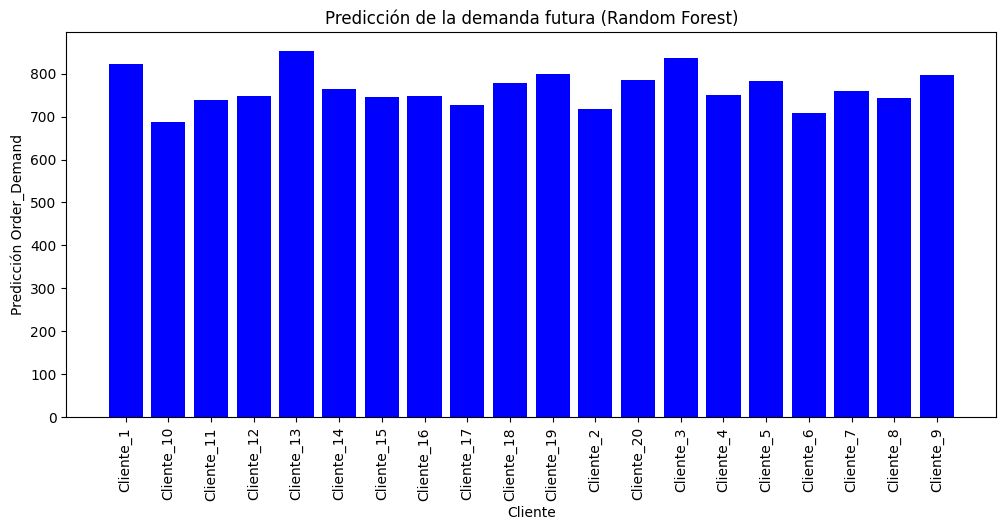

In [50]:
# Diccionario para almacenar las predicciones de cada cliente
predicciones = {}

# Iterar sobre cada cliente en el diccionario de datos
for cliente, df_cliente in clientes_data.items():
    # Asegurar que el DataFrame está ordenado por fecha
    df_cliente = df_cliente.sort_values(by='mes_anio_dia')

    # Seleccionar la última fila para obtener los valores de lag
    ultima_fila = df_cliente.iloc[-1]

    # Construir un DataFrame con una sola fila para la predicción
    X_nueva = pd.DataFrame({
        'lag_1': [ultima_fila['order_demand']],
        'lag_2': [df_cliente.iloc[-2]['order_demand'] if len(df_cliente) > 1 else ultima_fila['order_demand']],
        'lag_3': [df_cliente.iloc[-3]['order_demand'] if len(df_cliente) > 2 else ultima_fila['order_demand']],
        'lag_4': [df_cliente.iloc[-4]['order_demand'] if len(df_cliente) > 3 else ultima_fila['order_demand']],
        'lag_5': [df_cliente.iloc[-5]['order_demand'] if len(df_cliente) > 4 else ultima_fila['order_demand']],
        'lag_6': [df_cliente.iloc[-6]['order_demand'] if len(df_cliente) > 5 else ultima_fila['order_demand']],
        'lag_7': [df_cliente.iloc[-7]['order_demand'] if len(df_cliente) > 6 else ultima_fila['order_demand']],
        'lag_8': [df_cliente.iloc[-8]['order_demand'] if len(df_cliente) > 7 else ultima_fila['order_demand']],
        'lag_9': [df_cliente.iloc[-9]['order_demand'] if len(df_cliente) > 8 else ultima_fila['order_demand']],
        'lag_10': [df_cliente.iloc[-10]['order_demand'] if len(df_cliente) > 9 else ultima_fila['order_demand']],
        'lag_11': [df_cliente.iloc[-11]['order_demand'] if len(df_cliente) > 10 else ultima_fila['order_demand']],
        'lag_12': [df_cliente.iloc[-12]['order_demand'] if len(df_cliente) > 11 else ultima_fila['order_demand']]
    })

    # Usar el modelo para predecir la demanda del siguiente mes
    prediccion = best_rf_model.predict(X_nueva)[0]

    # Guardar la predicción en el diccionario
    predicciones[cliente] = prediccion

# Convertir a DataFrame para visualizar
df_predicciones_rf = pd.DataFrame(list(predicciones.items()), columns=['Cliente', 'Predicción Order_Demand'])
print(df_predicciones_rf)

# Gráfico de predicciones
plt.figure(figsize=(12, 5))
plt.bar(df_predicciones_rf['Cliente'], df_predicciones_rf['Predicción Order_Demand'], color='blue')
plt.xticks(rotation=90)
plt.xlabel("Cliente")
plt.ylabel("Predicción Order_Demand")
plt.title("Predicción de la demanda futura (Random Forest)")
plt.show()

In [ ]:
# Guardar las predicciones en un archivo CSV (opcional)
df_predicciones.to_csv("predicciones_random_forest.csv", index=False)
print("\nPredicciones guardadas en 'predicciones_random_forest.csv'.")

Modelo de ARIMA

In [51]:
# Verificar Estacionariedad para todos los clientes
resultados_estacionariedad = {}
clientes_estacionarios = []
clientes_no_estacionarios = []

for cliente, data_cliente in clientes_data.items():
    # Seleccionar solo la columna de demanda y ordenar por fecha
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    # Prueba ADF (Dickey-Fuller Aumentada)
    result_adf = adfuller(data_cliente['order_demand'])
    p_valor = result_adf[1]  # Extraemos el p-valor para verificar la estacionariedad

    # Guardar resultados
    es_estacionaria = p_valor <= 0.05
    resultados_estacionariedad[cliente] = {
        'es_estacionaria': es_estacionaria,
        'p_valor': p_valor,
        'estadistico_adf': result_adf[0],
        'razon': 'Serie estacionaria' if es_estacionaria else 'p-valor > 0.05, no estacionaria'
    }

    # Clasificar correctamente los clientes
    if es_estacionaria:
        clientes_estacionarios.append(cliente)
    else:
        clientes_no_estacionarios.append(cliente)

# Resumen final
print("\nClientes con series estacionarias:")
print(clientes_estacionarios)

print("\nClientes con series no estacionarias:")
print(clientes_no_estacionarios)

# Verificación adicional
print("\nResumen detallado de la prueba Dickey-Fuller:")
for cliente, info in resultados_estacionariedad.items():
    print(f"{cliente}: {info['razon']} (p-valor: {info['p_valor']:.4f})")



Clientes con series estacionarias:
['Cliente_1', 'Cliente_10', 'Cliente_14', 'Cliente_15', 'Cliente_20', 'Cliente_3', 'Cliente_4', 'Cliente_6', 'Cliente_7', 'Cliente_9']

Clientes con series no estacionarias:
['Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_16', 'Cliente_17', 'Cliente_18', 'Cliente_19', 'Cliente_2', 'Cliente_5', 'Cliente_8']

Resumen detallado de la prueba Dickey-Fuller:
Cliente_1: Serie estacionaria (p-valor: 0.0000)
Cliente_10: Serie estacionaria (p-valor: 0.0000)
Cliente_11: p-valor > 0.05, no estacionaria (p-valor: 0.9840)
Cliente_12: p-valor > 0.05, no estacionaria (p-valor: 0.8394)
Cliente_13: p-valor > 0.05, no estacionaria (p-valor: 0.6173)
Cliente_14: Serie estacionaria (p-valor: 0.0000)
Cliente_15: Serie estacionaria (p-valor: 0.0000)
Cliente_16: p-valor > 0.05, no estacionaria (p-valor: 0.2869)
Cliente_17: p-valor > 0.05, no estacionaria (p-valor: 0.8727)
Cliente_18: p-valor > 0.05, no estacionaria (p-valor: 0.1637)
Cliente_19: p-valor > 0.05, no estacio

In [52]:
# Aplicar diferenciación a las series no estacionarias
clientes_a_diferenciar = clientes_no_estacionarios.copy()
clientes_a_reintentar = []  # Para los clientes que aún no sean estacionarios tras d=1

print("\nResultados de la prueba ADF después de la diferenciación:")

for cliente in clientes_a_diferenciar:
    # Aplicar diferenciación de primer orden (d=1)
    clientes_data[cliente]['order_demand_diff1'] = clientes_data[cliente]['order_demand'].diff().dropna()
    result_adf_diff1 = adfuller(clientes_data[cliente]['order_demand_diff1'].dropna())
    
    # Evaluar si con d=1 la serie ya es estacionaria
    if result_adf_diff1[1] <= 0.05:
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | Estacionaria")
    else:
        clientes_a_reintentar.append(cliente)
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | No estacionaria, se probará con d=2")

# Aplicar diferenciación de segundo orden (d=2) si es necesario
if clientes_a_reintentar:
    print("\nAplicando diferenciación de segundo orden (d=2) para clientes restantes...\n")
    for cliente in clientes_a_reintentar:
        # Aplicar diferenciación de segundo orden (d=2)
        clientes_data[cliente]['order_demand_diff2'] = clientes_data[cliente]['order_demand_diff1'].diff().dropna()
        result_adf_diff2 = adfuller(clientes_data[cliente]['order_demand_diff2'].dropna())

        # Evaluar si con d=2 la serie es estacionaria
        if result_adf_diff2[1] <= 0.05:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Estacionaria")
        else:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Aún no estacionaria")



Resultados de la prueba ADF después de la diferenciación:
Cliente_11 | d=1 | p-valor: 0.0138 | Estacionaria
Cliente_12 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_13 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_16 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_17 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_18 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_19 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_2 | d=1 | p-valor: 0.0001 | Estacionaria
Cliente_5 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_8 | d=1 | p-valor: 0.0001 | Estacionaria


In [53]:
# Asignar d_inicial
# Crear diccionario para almacenar el valor de d inicial
d_inicial_por_cliente = {}

# Asignar d=0 a los clientes que eran estacionarios desde el inicio
for cliente in clientes_estacionarios:
    d_inicial_por_cliente[cliente] = 0  

# Asignar d=1 a los clientes que requirieron diferenciación
for cliente in clientes_no_estacionarios:  # Es lo mismo que clientes_diferenciados
    d_inicial_por_cliente[cliente] = 1  

# Mostrar los valores asignados
print("Parámetro d inicial por cliente:")
for cliente, d in d_inicial_por_cliente.items():
    print(f"{cliente}: d={d}")


Parámetro d inicial por cliente:
Cliente_1: d=0
Cliente_10: d=0
Cliente_14: d=0
Cliente_15: d=0
Cliente_20: d=0
Cliente_3: d=0
Cliente_4: d=0
Cliente_6: d=0
Cliente_7: d=0
Cliente_9: d=0
Cliente_11: d=1
Cliente_12: d=1
Cliente_13: d=1
Cliente_16: d=1
Cliente_17: d=1
Cliente_18: d=1
Cliente_19: d=1
Cliente_2: d=1
Cliente_5: d=1
Cliente_8: d=1


In [54]:
# Diccionario para almacenar los mejores modelos
best_models = {}

# Rango de valores a probar para p, d y q
p_values = range(0, 3)  # p = 0,1,2
d_values = range(0, 3)  # d = 0,1,2 (evaluar todas las opciones)
q_values = range(0, 3)  # q = 0,1,2

# Iterar sobre cada cliente en clientes_data
for cliente, data_cliente in clientes_data.items():
    # print(f"\nProcesando cliente: {cliente}")

    # Seleccionar la serie temporal y ordenar por fecha
    series_to_use = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()
    series_to_use = series_to_use['order_demand'].dropna()

    # Asignar d mínimo según el análisis previo
    d_min = d_inicial_por_cliente[cliente]

    best_aic = np.inf
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros p, d y q
    for d in d_values:
        if d < d_min:
            continue  # Saltar valores de d que no cumplen la mínima diferenciación

        for p in p_values:
            for q in q_values:
                try:
                    model = ARIMA(series_to_use, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluar AIC
                    aic = model_fit.aic

                    # Validación: Evitar modelos degenerados (como Cliente_20 con AIC=10.0)
                    if aic < 50:  
                        print(f"⚠️ AIC sospechosamente bajo ({aic}) para {cliente} con ARIMA({p},{d},{q}) - Modelo descartado")
                        continue

                    # Guardar el mejor modelo encontrado
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception:
                    continue  # Ignorar errores y continuar con la siguiente combinación

    # Almacenar el mejor modelo para este cliente
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic}")


Mejor modelo para Cliente_1: ARIMA(0, 2, 2) - AIC: 648.1341084730429
Mejor modelo para Cliente_10: ARIMA(0, 2, 2) - AIC: 677.5643292201984
Mejor modelo para Cliente_11: ARIMA(2, 2, 2) - AIC: 600.9641207726299
Mejor modelo para Cliente_12: ARIMA(2, 1, 2) - AIC: 588.0695511793515
Mejor modelo para Cliente_13: ARIMA(2, 1, 2) - AIC: 588.5811385739278
Mejor modelo para Cliente_14: ARIMA(0, 2, 2) - AIC: 613.8110961312653
Mejor modelo para Cliente_15: ARIMA(0, 2, 2) - AIC: 634.2665766100978
Mejor modelo para Cliente_16: ARIMA(2, 1, 2) - AIC: 576.0209308078336
Mejor modelo para Cliente_17: ARIMA(2, 1, 2) - AIC: 589.2778861253635
Mejor modelo para Cliente_18: ARIMA(2, 1, 2) - AIC: 583.1379070074023
Mejor modelo para Cliente_19: ARIMA(2, 1, 2) - AIC: 578.1261933111332
Mejor modelo para Cliente_2: ARIMA(0, 2, 2) - AIC: 583.3253642160191
⚠️ AIC sospechosamente bajo (10.0) para Cliente_20 con ARIMA(2,2,2) - Modelo descartado
Mejor modelo para Cliente_20: ARIMA(0, 2, 2) - AIC: 686.0246973247639
Mejo

           Mejor ARIMA         AIC     MAE        MSE    RMSE      R²
Cliente_1    (0, 2, 2)  648.134108   67.42    9650.26   98.24 -0.2206
Cliente_10   (0, 2, 2)  677.564329  105.31   16017.72  126.56 -0.6382
Cliente_11   (2, 2, 2)  600.964121  102.76   25530.64  159.78  0.1742
Cliente_12   (2, 1, 2)  588.069551   54.83    7777.72   88.19  0.4665
Cliente_13   (2, 1, 2)  588.581139   72.35     7985.9   89.36  0.3454
Cliente_14   (0, 2, 2)  613.811096   85.83   10547.29   102.7 -0.1008
Cliente_15   (0, 2, 2)  634.266577  101.54   14567.68   120.7 -0.0867
Cliente_16   (2, 1, 2)  576.020931   64.13    5885.27   76.72  0.4019
Cliente_17   (2, 1, 2)  589.277886   79.19   10393.86  101.95  0.1049
Cliente_18   (2, 1, 2)  583.137907   77.97    9221.52   96.03  0.3806
Cliente_19   (2, 1, 2)  578.126193   63.22    7106.06    84.3  0.2235
Cliente_2    (0, 2, 2)  583.325364   73.08   10479.07  102.37 -0.0696
Cliente_20   (0, 2, 2)  686.024697  259.45  306254.87   553.4 -0.1407
Cliente_3    (0, 1, 

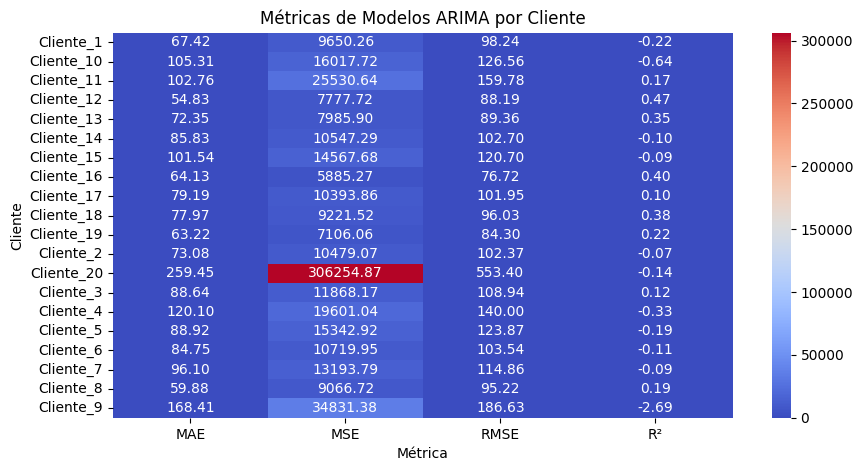

In [55]:
# Métricas de Evaluación para Modelos ARIMA 

# Diccionario para almacenar los resultados de las métricas
resultados_arima = {}

for cliente, info in best_models.items():
    modelo = info['model']  # Obtener el mejor modelo
    if modelo is None:
        print(f"No se encontró un modelo válido para {cliente}.")
        continue

    # Obtener datos originales del cliente
    data_cliente = clientes_data[cliente][['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    # Definir datos de prueba y predicciones
    y_test = data_cliente['order_demand'].iloc[-12:]  # Últimos 12 valores como test
    y_pred = modelo.predict(start=len(data_cliente)-12, end=len(data_cliente)-1)

    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    resultados_arima[cliente] = {
        'Mejor ARIMA': info['order'],
        'AIC': info['aic'],
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    }

# Convertir resultados a DataFrame para visualización
df_resultados_arima = pd.DataFrame(resultados_arima).T

# Mostrar las métricas como tabla
print(df_resultados_arima)

# Visualizar las métricas con heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_resultados_arima[['MAE', 'MSE', 'RMSE', 'R²']].astype(float), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Métricas de Modelos ARIMA por Cliente")
plt.xlabel("Métrica")
plt.ylabel("Cliente")
plt.show()


Predicciones

       Cliente  Predicción Order_Demand
0    Cliente_1               654.112497
1   Cliente_10               754.857248
2   Cliente_11               854.421753
3   Cliente_12               725.268537
4   Cliente_13               765.330618
5   Cliente_14               691.537499
6   Cliente_15               691.238523
7   Cliente_16               745.911407
8   Cliente_17               754.900979
9   Cliente_18               825.574139
10  Cliente_19               734.075749
11   Cliente_2               687.454978
12  Cliente_20               774.115946
13   Cliente_3               841.005884
14   Cliente_4               721.472409
15   Cliente_5               690.101146
16   Cliente_6               682.830379
17   Cliente_7               664.783718
18   Cliente_8               819.568242
19   Cliente_9               782.377661


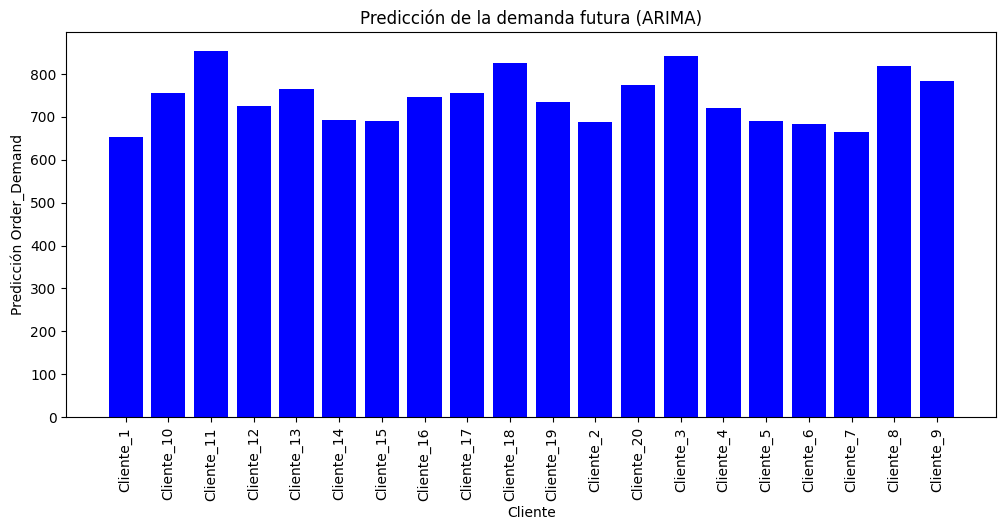

In [56]:
predicciones_arima = {}

# Período de predicción (predecir un mes en adelante)
num_periodos_prediccion = 1  

# Realizar predicciones con los mejores modelos ARIMA para cada cliente
for cliente, info in best_models.items():
    modelo = info['model']
    
    if modelo is not None:
        try:
            # Realizar predicción para el próximo mes
            prediccion = modelo.forecast(steps=num_periodos_prediccion)
            predicciones_arima[cliente] = prediccion.iloc[0]
        except Exception as e:
            predicciones_arima[cliente] = None
            print(f"Error al predecir para {cliente}: {e}")

# Convertir a DataFrame
df_predicciones_arima = pd.DataFrame(
    list(predicciones_arima.items()), 
    columns=['Cliente', 'Predicción Order_Demand']
)

# Visualizar predicciones en una tabla
print(df_predicciones_arima)

# Gráfico de predicciones
plt.figure(figsize=(12, 5))
plt.bar(df_predicciones_arima['Cliente'], df_predicciones_arima['Predicción Order_Demand'], color='blue')
plt.xticks(rotation=90)
plt.xlabel("Cliente")
plt.ylabel("Predicción Order_Demand")
plt.title("Predicción de la demanda futura (ARIMA)")
plt.show()


Comparación RMSE de ARIMA vs. Random Forest


📊 Comparación de Modelos (ARIMA vs Random Forest)

               RMSE_RF      MAE_RF         MSE_RF     R2_RF RMSE_ARIMA  \
Cliente_1    59.427019   46.232778    3531.570635  0.677885      98.24   
Cliente_10  133.178616   86.131830   17736.543719 -0.499112     126.56   
Cliente_11  220.136805  113.144830   48460.213128 -0.201525     159.78   
Cliente_12   68.892992   48.073685    4746.244392  0.700721      88.19   
Cliente_13   64.761991   52.153968    4194.115415  0.729310      89.36   
Cliente_14   53.796630   43.549357    2894.077396  0.780802      102.7   
Cliente_15   68.307705   58.901689    4665.942555  0.719703      120.7   
Cliente_16   61.868166   55.141377    3827.669948  0.704774      76.72   
Cliente_17   59.234491   48.051944    3508.724928  0.774565     101.95   
Cliente_18   79.182146   75.794540    6269.812324  0.681718      96.03   
Cliente_19   70.508084   55.541250    4971.389964  0.575156       84.3   
Cliente_2    95.788356   53.818098    9175.409097  0.302313 

<Figure size 1200x600 with 0 Axes>

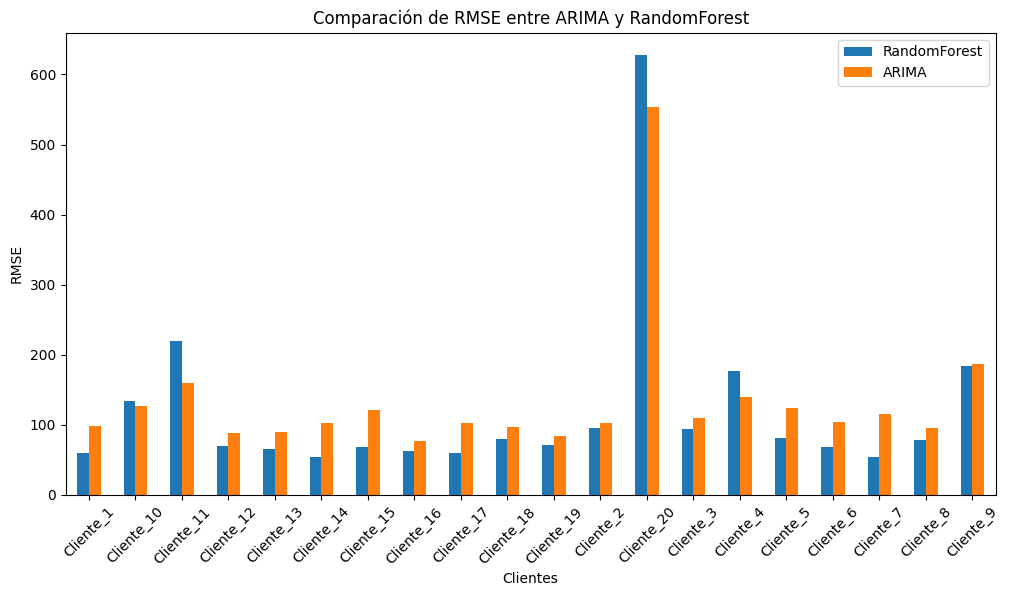

In [60]:
df_resultados_arima = df_resultados_arima.rename(columns={
    'RMSE': 'RMSE_ARIMA',
    'MAE': 'MAE_ARIMA',
    'MSE': 'MSE_ARIMA',
    'R²': 'R2_ARIMA'
})

# Unir los resultados de ambos modelos para comparación
df_comparacion = df_resultados_rf.join(df_resultados_arima[['RMSE_ARIMA', 'MAE_ARIMA', 'MSE_ARIMA', 'R2_ARIMA']], how='inner')

# Comparación basada en RMSE (menor es mejor)
df_comparacion['Mejor_Modelo_RMSE'] = df_comparacion.apply(
    lambda row: 'ARIMA' if row['RMSE_ARIMA'] < row['RMSE_RF'] else 'RandomForest', axis=1
)

# Comparación basada en R² (mayor es mejor)
df_comparacion['Mejor_Modelo_R2'] = df_comparacion.apply(
    lambda row: 'ARIMA' if row['R2_ARIMA'] > row['R2_RF'] else 'RandomForest', axis=1
)

# Mostrar DataFrame en consola
print("\n📊 Comparación de Modelos (ARIMA vs Random Forest)\n")
print(df_comparacion)

# Graficar Comparación RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_comparacion[['RMSE_RF', 'RMSE_ARIMA']].plot(kind='bar', figsize=(12,6))
plt.title("Comparación de RMSE entre ARIMA y RandomForest")
plt.ylabel("RMSE")
plt.xlabel("Clientes")
plt.xticks(rotation=45)
plt.legend(["RandomForest", "ARIMA"])
plt.show()


In [61]:
# Crear un nuevo DataFrame para la comparación con MAPE
df_comparacion_mape = df_comparacion.copy()

# Calcular MAPE (Mean Absolute Percentage Error) para cada modelo
df_comparacion_mape['MAPE_RF'] = (df_resultados_rf['MAE_RF'] / df_resultados_rf['RMSE_RF']) * 100
df_comparacion_mape['MAPE_ARIMA'] = (df_resultados_arima['MAE_ARIMA'] / df_resultados_arima['RMSE_ARIMA']) * 100

# Comparación basada en MAPE (menor es mejor)
df_comparacion_mape['Mejor_Modelo_MAPE'] = df_comparacion_mape.apply(
    lambda row: 'ARIMA' if row['MAPE_ARIMA'] < row['MAPE_RF'] else 'RandomForest', axis=1
)

# Mostrar tabla con la nueva métrica
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)  # Formato para mejorar visualización

print("\n📊 Comparación Final de Modelos con MAPE\n")
print(df_comparacion_mape)
df_comparacion_mape



📊 Comparación Final de Modelos con MAPE

            RMSE_RF  MAE_RF    MSE_RF  R2_RF RMSE_ARIMA MAE_ARIMA MSE_ARIMA  \
Cliente_1     59.43   46.23   3531.57   0.68      98.24     67.42   9650.26   
Cliente_10   133.18   86.13  17736.54  -0.50     126.56    105.31  16017.72   
Cliente_11   220.14  113.14  48460.21  -0.20     159.78    102.76  25530.64   
Cliente_12    68.89   48.07   4746.24   0.70      88.19     54.83   7777.72   
Cliente_13    64.76   52.15   4194.12   0.73      89.36     72.35   7985.90   
Cliente_14    53.80   43.55   2894.08   0.78     102.70     85.83  10547.29   
Cliente_15    68.31   58.90   4665.94   0.72     120.70    101.54  14567.68   
Cliente_16    61.87   55.14   3827.67   0.70      76.72     64.13   5885.27   
Cliente_17    59.23   48.05   3508.72   0.77     101.95     79.19  10393.86   
Cliente_18    79.18   75.79   6269.81   0.68      96.03     77.97   9221.52   
Cliente_19    70.51   55.54   4971.39   0.58      84.30     63.22   7106.06   
Cliente_2 

,RMSE_RF,MAE_RF,MSE_RF,R2_RF,RMSE_ARIMA,MAE_ARIMA,MSE_ARIMA,R2_ARIMA,Mejor_Modelo_RMSE,Mejor_Modelo_R2,MAPE_RF,MAPE_ARIMA,Mejor_Modelo_MAPE
Cliente_1,59.43,46.23,3531.57,0.68,98.24,67.42,9650.26,-0.22,RandomForest,RandomForest,77.80,68.63,ARIMA
Cliente_10,133.18,86.13,17736.54,-0.50,126.56,105.31,16017.72,-0.64,ARIMA,RandomForest,64.67,83.21,RandomForest
Cliente_11,220.14,113.14,48460.21,-0.20,159.78,102.76,25530.64,0.17,ARIMA,ARIMA,51.40,64.31,RandomForest
Cliente_12,68.89,48.07,4746.24,0.70,88.19,54.83,7777.72,0.47,RandomForest,RandomForest,69.78,62.17,ARIMA
Cliente_13,64.76,52.15,4194.12,0.73,89.36,72.35,7985.90,0.35,RandomForest,RandomForest,80.53,80.96,RandomForest
Cliente_14,53.80,43.55,2894.08,0.78,102.70,85.83,10547.29,-0.10,RandomForest,RandomForest,80.95,83.57,RandomForest
Cliente_15,68.31,58.90,4665.94,0.72,120.70,101.54,14567.68,-0.09,RandomForest,RandomForest,86.23,84.13,ARIMA
Cliente_16,61.87,55.14,3827.67,0.70,76.72,64.13,5885.27,0.40,RandomForest,RandomForest,89.13,83.59,ARIMA
Cliente_17,59.23,48.05,3508.72,0.77,101.95,79.19,10393.86,0.10,RandomForest,RandomForest,81.12,77.68,ARIMA
Cliente_18,79.18,75.79,6269.81,0.68,96.03,77.97,9221.52,0.38,RandomForest,RandomForest,95.72,81.19,ARIMA


Análisis de los resultados.

Random Forest obtiene mejores resultados en la mayoría de los clientes, con menor RMSE y mayor R².

ARIMA supera en algunos casos (ejemplo: Cliente_10 en RMSE y Cliente_4 en ambas métricas).

Cliente_20 sigue siendo problemático, con valores extremadamente altos de error.

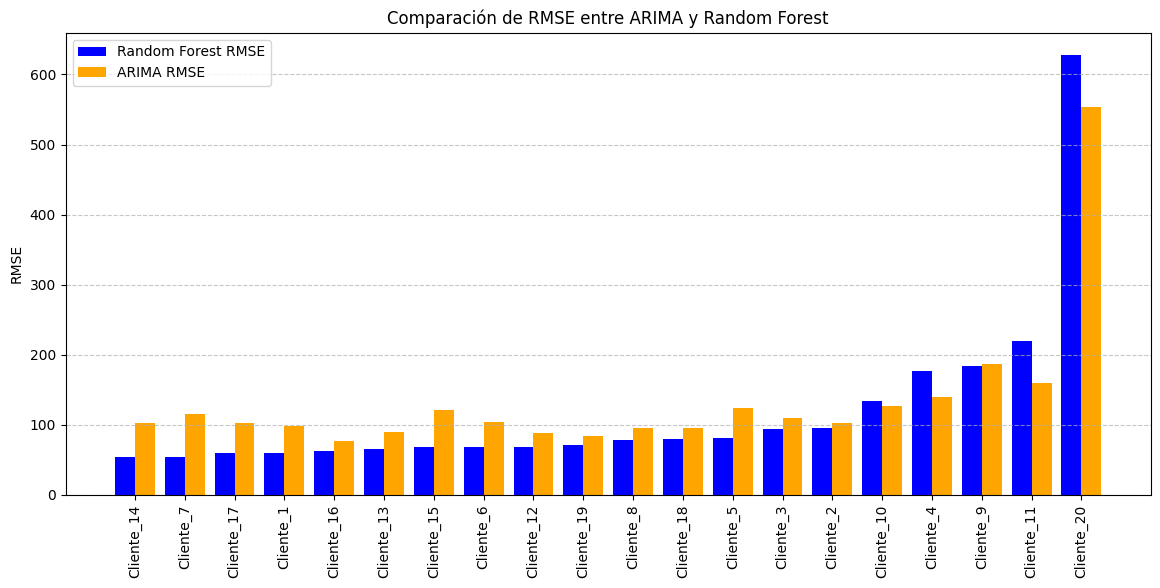

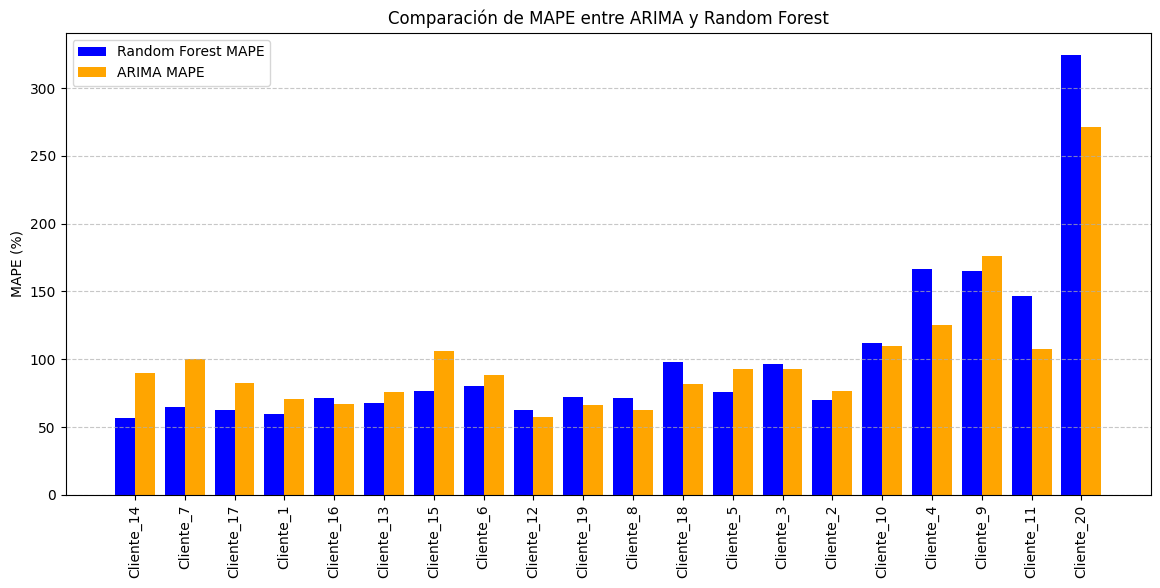

In [62]:
# Código para Visualización de RMSE y MAPE

df_comparacion_final = df_comparacion.copy()
df_comparacion_final["MAPE_RF"] = (abs(df_comparacion_final["MAE_RF"]) / df_comparacion_final["MAE_RF"].mean()) * 100
df_comparacion_final["MAPE_ARIMA"] = (abs(df_comparacion_final["MAE_ARIMA"]) / df_comparacion_final["MAE_ARIMA"].mean()) * 100
df_comparacion_final = df_comparacion_final.sort_values(by="RMSE_RF")

# Gráfico de barras comparando RMSE
plt.figure(figsize=(14, 6))
bar_width = 0.4
clientes = np.arange(len(df_comparacion_final))

plt.bar(clientes - bar_width / 2, df_comparacion_final["RMSE_RF"], width=bar_width, label="Random Forest RMSE", color="blue")
plt.bar(clientes + bar_width / 2, df_comparacion_final["RMSE_ARIMA"], width=bar_width, label="ARIMA RMSE", color="orange")

plt.xticks(clientes, df_comparacion_final.index, rotation=90)
plt.ylabel("RMSE")
plt.title("Comparación de RMSE entre ARIMA y Random Forest")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Gráfico de barras comparando MAPE
plt.figure(figsize=(14, 6))

plt.bar(clientes - bar_width / 2, df_comparacion_final["MAPE_RF"], width=bar_width, label="Random Forest MAPE", color="blue")
plt.bar(clientes + bar_width / 2, df_comparacion_final["MAPE_ARIMA"], width=bar_width, label="ARIMA MAPE", color="orange")

plt.xticks(clientes, df_comparacion_final.index, rotation=90)
plt.ylabel("MAPE (%)")
plt.title("Comparación de MAPE entre ARIMA y Random Forest")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Comparación de Predicciones


📊 Comparación de Predicciones entre ARIMA y Random Forest
       Cliente  Predicción Order_Demand_ARIMA  Predicción Order_Demand_RF  \
0    Cliente_1                         654.11                      822.04   
1   Cliente_10                         754.86                      687.34   
2   Cliente_11                         854.42                      739.07   
3   Cliente_12                         725.27                      747.67   
4   Cliente_13                         765.33                      853.67   
5   Cliente_14                         691.54                      764.43   
6   Cliente_15                         691.24                      745.31   
7   Cliente_16                         745.91                      748.32   
8   Cliente_17                         754.90                      727.99   
9   Cliente_18                         825.57                      777.86   
10  Cliente_19                         734.08                      798.82   
11   Cliente_2   

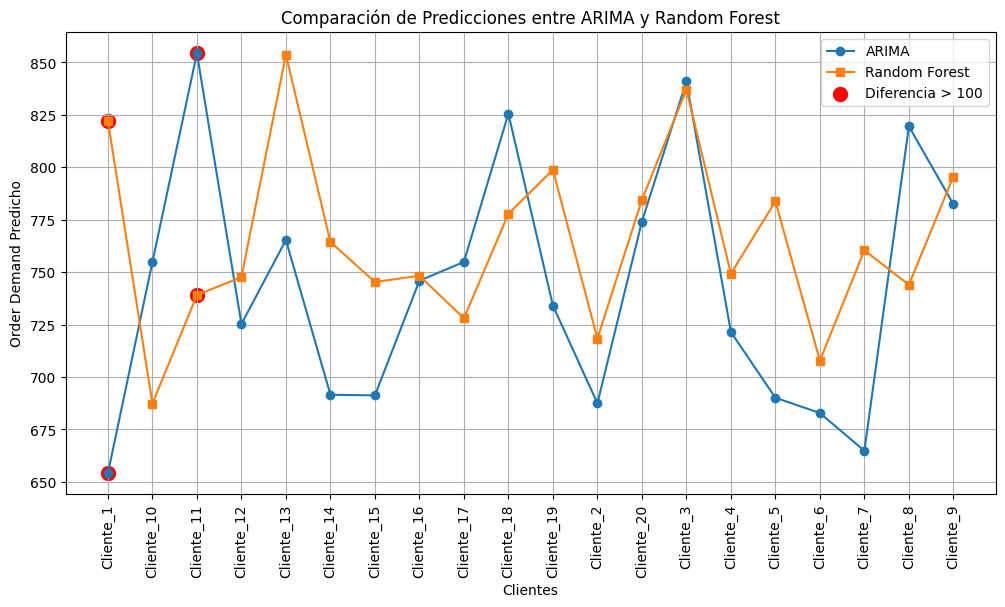

,Cliente,Predicción Order_Demand_ARIMA,Predicción Order_Demand_RF,Diferencia_Abs
0,Cliente_1,654.11,822.04,167.93
1,Cliente_10,754.86,687.34,67.52
2,Cliente_11,854.42,739.07,115.35
3,Cliente_12,725.27,747.67,22.40
4,Cliente_13,765.33,853.67,88.34
5,Cliente_14,691.54,764.43,72.89
6,Cliente_15,691.24,745.31,54.07
7,Cliente_16,745.91,748.32,2.41
8,Cliente_17,754.90,727.99,26.91
9,Cliente_18,825.57,777.86,47.71


In [64]:
# Crear un DataFrame combinando ambas predicciones
df_comparacion_predicciones = df_predicciones_arima.merge(
    df_predicciones_rf, on="Cliente", suffixes=("_ARIMA", "_RF")
)

# Calcular diferencia absoluta entre ambos modelos
df_comparacion_predicciones["Diferencia_Abs"] = abs(
    df_comparacion_predicciones["Predicción Order_Demand_ARIMA"] - df_comparacion_predicciones["Predicción Order_Demand_RF"]
)

# Filtrar clientes con diferencia > 100
clientes_diferencia_alta = df_comparacion_predicciones[df_comparacion_predicciones["Diferencia_Abs"] > 100]

# Mostrar la tabla con diferencias destacadas
print("\n📊 Comparación de Predicciones entre ARIMA y Random Forest")
print(df_comparacion_predicciones)

# Graficar la comparación
plt.figure(figsize=(12, 6))

clientes = df_comparacion_predicciones["Cliente"]
arima_preds = df_comparacion_predicciones["Predicción Order_Demand_ARIMA"]
rf_preds = df_comparacion_predicciones["Predicción Order_Demand_RF"]

plt.plot(clientes, arima_preds, marker='o', linestyle='-', label="ARIMA")
plt.plot(clientes, rf_preds, marker='s', linestyle='-', label="Random Forest")

# Resaltar los clientes con mayor diferencia en la gráfica
for i, row in clientes_diferencia_alta.iterrows():
    plt.scatter(row["Cliente"], row["Predicción Order_Demand_ARIMA"], color='red', s=100, label="Diferencia > 100" if i == clientes_diferencia_alta.index[0] else "")
    plt.scatter(row["Cliente"], row["Predicción Order_Demand_RF"], color='red', s=100)

plt.xticks(rotation=90)
plt.xlabel("Clientes")
plt.ylabel("Order Demand Predicho")
plt.title("Comparación de Predicciones entre ARIMA y Random Forest")
plt.legend()
plt.grid()
plt.show()

df_comparacion_predicciones

# Caso 4
Para el caso 4 hemos decidido añadir la variable tiempo al algoritmo genético para hacer un analisis de como se modificarían las rutas para poder realizar el envio intentando reducir tanto costes como tiempo.


In [ ]:
def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_time = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        ruta_time = 0
        carga_total = 0
        vehicle_cost_per_km = df_vehiculos.loc[i, 'costo_km']  # Costo por kilómetro del vehículo

        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                time = df_time_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            ruta_time += time
            carga_total += pedido_size

        # Calcular costo de la ruta
        ruta_cost = ruta_distance * vehicle_cost_per_km
        total_cost += ruta_cost

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        total_distance += ruta_distance
        total_time += ruta_time

    # Asegúrate de retornar una tupla de tres valores
    return (total_distance + penalty, total_time, total_cost)

def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]],  # Recompone la ruta


In [ ]:

##CASO 4 CON VARIABLE TIEMPO
# Crear tipos personalizados en DEAP
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))  # Minimizar distancia, tiempo y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Definición de la función para generar individuos
def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_time = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        ruta_time = 0
        ruta_cost = 0
        carga_total = 0

        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                time = df_time_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            ruta_time += time
            carga_total += pedido_size
            ruta_cost += distance * df_vehiculos.loc[i, 'costo_km']

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        total_distance += ruta_distance
        total_time += ruta_time
        total_cost += ruta_cost

    return (total_distance + penalty, total_time, total_cost)

# Operadores genéticos
def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]

# Configuración de DEAP
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo evolutivo
ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=200)

ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

    fits = [ind.fitness.values for ind in population]

    min_dist = min(f[0] for f in fits)
    min_time = min(f[1] for f in fits)
    min_cost = min(f[2] for f in fits)
    # print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Tiempo Min = {min_time}, Costo Min = {min_cost}")

# Mostrar la mejor solución
best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas2 = []
total_cost = 0

for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    ruta_time = 0
    ruta_cost = 0
    carga_total = 0

    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        ruta_time += df_time_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
        ruta_cost += distance_km_array[city_a][city_b] * df_vehiculos.loc[i, 'costo_km']

    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos.loc[i, 'autonomia_km']} km)")
    print(f"  Tiempo total: {ruta_time:.2f} minutos")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos.loc[i, 'capacidad_kg']})")
    print(f"  Costo total: {ruta_cost:.2f} (Costo por km: {df_vehiculos.loc[i, 'costo_km']})")
    diccionario = {"vehiculo" : i, "ruta" : ruta}
    lista_rutas2.append(diccionario)

print(f"\nCosto total de la solución: {total_cost:.2f}")


In [ ]:
df_locations = pd.read_excel("../dataset/df_location.xlsx")
df_locations

In [ ]:

for elemento in lista_rutas2:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones
lista_rutas2

df_rutas_elementos2 = pd.DataFrame(lista_rutas2)
df_rutas_elementos2

In [ ]:
coordenadas = [coord for ruta in df_rutas_elementos2['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos2.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes_tiempo.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m